In [1]:
import pandas as pd
import numpy as np

## Data Load

In [2]:
# 온도경로의 파일 리스트 가져오기
import os
path = '../Temperature/'

file_list = os.listdir(path)
file_list_py = [file for file in file_list if file.endswith('.txt')]
print(file_list_py)

## csv 파일들을 DataFrame으로 불러와서 concat
df= pd.DataFrame()
for i in file_list_py:
    data = pd.read_csv(path + i, sep='\t', encoding = 'cp949')

    df = pd.concat([df,data])    
df_tmeperature = df.reset_index(drop = True)

['온도_2012-04.txt', '온도_2012-05.txt', '온도_2012-08.txt', '온도_2012-02.txt', '온도_2012-03.txt', '온도_2012-07.txt', '온도_2012-09.txt', '온도_2012-10.txt', '온도_2012-06.txt', '온도_2012-01.txt']


In [3]:
# 전력경로의 파일 리스트 가져오기
import os
path = '../Power/'

file_list = os.listdir(path)
file_list_py = [file for file in file_list if file.endswith('.txt')]
print(file_list_py)

## csv 파일들을 DataFrame으로 불러와서 concat
df= pd.DataFrame()
for i in file_list_py:
    data = pd.read_csv(path + i, sep='\t', encoding = 'cp949')
    df = pd.concat([df,data])
df_power = df.reset_index(drop = True)


['전력_2012-03.txt', '전력_2012-04.txt', '전력_2012-05.txt', '전력_2012-06.txt', '전력_2012-09.txt', '전력_2012-07.txt', '전력_2012-10.txt', '전력_2012-02.txt', '전력_2012-01.txt', '전력_2012-08.txt']


In [4]:
print(df_tmeperature.shape, df_power.shape)

(41670, 149) (159104, 151)


## 가전기기 이름 재태그하기

In [5]:
# 가전 태그하기
df_power['PointName'].value_counts()

전력총합         25292
TV           20717
데스크탑PC       17432
전기밥솥         17333
세탁기          14875
             ...  
전기맛사지기          17
밥솥              12
김치냉장고(구형)        9
오븐               8
셋톱박스             2
Name: PointName, Length: 90, dtype: int64

In [6]:
df_power.loc[df_power.PointName.str.contains('냉장고'),'PointName'].unique()

array(['냉장고', '김치냉장고', '김치냉장고(신형)', '김치냉장고(구형)', '냉장고1', '냉장고2'],
      dtype=object)

In [7]:
df_power.loc[df_power.PointName.str.contains('냉장고'),'PointName'] = '냉장고'
df_power.loc[df_power.PointName.str.contains('선풍기'),'PointName']= '선풍기'
df_power.loc[df_power.PointName.str.contains('냉풍기'),'PointName']= '냉풍기'
df_power.loc[df_power.PointName.str.contains('TV'),'PointName'] ='TV'
df_power.loc[df_power.PointName.str.contains('PC'),'PointName'] = '컴퓨터'
df_power.loc[df_power.PointName.str.contains('노트북'),'PointName'] = '컴퓨터'
df_power.loc[df_power.PointName.str.contains('밥솥'),'PointName'] = '밥솥'
df_power.loc[df_power.PointName.str.contains('쿠쿠'),'PointName'] = '밥솥'

df_power.loc[df_power.HA.str.contains('전력총합'),'HA'] = '전력총합'

In [8]:
df_power = df_power.reset_index(drop = True)
df_power.head(2)

,H_ID,HA,ST_DATE,APT_TF,M2,PersonCount,PointName,H00_1,H00_2,H00_3,...,H22_3,H22_4,H22_5,H22_6,H23_1,H23_2,H23_3,H23_4,H23_5,H23_6
0,1,전력총합,2012-03-01,아파트,20평~29평,2인이하,전력총합,0.009,0.009,0.021,...,0.039,0.037,0.029,0.027,0.033,0.041,0.033,0.036,0.051,0.054
1,1,전력총합,2012-03-02,아파트,20평~29평,2인이하,전력총합,0.052,0.051,0.043,...,0.087,0.069,0.046,0.090,0.082,0.072,0.194,0.091,0.086,0.067


In [9]:
df_power.loc[df_power.PointName.str.contains('밥솥'),'PointName'].unique() 

array(['밥솥'], dtype=object)

In [10]:
# df_power.to_csv('전력사용량.csv', encoding = 'euc-kr')

## Derived Columns (Summed_hour, month, day, weekday) ...

In [11]:
# NA는 0으로 -> 센서가 인식을 못한 경우 NA
df_power.fillna(0, inplace = True)

In [12]:
def num_summed_col(column_name, hour):
    hour_string = '0' + str(hour)
    hour_string = hour_string[-2:]
    summed_col = df_power.loc[:, column_name + hour_string + '_1'].copy(deep=True)
    df_power.drop(columns=column_name + hour_string + '_1', inplace=True)
    for i in range(2,7):
        col = column_name + hour_string + '_{}'.format(i)
        summed_col += df_power.loc[:,col]
        df_power.drop(columns=col, inplace=True)
    return summed_col

In [13]:
power_day = None
for hour in range(24):
    new_hour_name = f'H{hour}'
    df_power[new_hour_name] = num_summed_col('H', hour)
    if type(power_day) == type(None):
        power_day = df_power[new_hour_name]
    else:
        power_day += df_power[new_hour_name]
df_power['day_consume'] = power_day

In [14]:
df_power.columns

Index(['H_ID', 'HA', 'ST_DATE', 'APT_TF', 'M2', 'PersonCount', 'PointName',
       'H0', 'H1', 'H2', 'H3', 'H4', 'H5', 'H6', 'H7', 'H8', 'H9', 'H10',
       'H11', 'H12', 'H13', 'H14', 'H15', 'H16', 'H17', 'H18', 'H19', 'H20',
       'H21', 'H22', 'H23', 'day_consume'],
      dtype='object')

In [15]:
# yyyy-mm-dd에서 년도와 월 데이터 생성
def processing(df):
    df['ST_DATE'] = pd.to_datetime(df['ST_DATE'])
    df['month'] = df['ST_DATE'].dt.month
    df['day'] = df['ST_DATE'].dt.day
    df['weekday']= df['ST_DATE'].dt.weekday
   # df.drop(['ST_DATE'], axis = 1, inplace = True)
    return df.head()

processing(df_power)

,H_ID,HA,ST_DATE,APT_TF,M2,PersonCount,PointName,H0,H1,H2,...,H18,H19,H20,H21,H22,H23,day_consume,month,day,weekday
0,1,전력총합,2012-03-01,아파트,20평~29평,2인이하,전력총합,0.086,0.086,0.087,...,0.084,0.104,0.135,0.231,0.251,0.248,2.642,3,1,3
1,1,전력총합,2012-03-02,아파트,20평~29평,2인이하,전력총합,0.311,0.200,0.128,...,0.088,0.080,0.295,0.337,0.417,0.592,4.191,3,2,4
2,1,전력총합,2012-03-03,아파트,20평~29평,2인이하,전력총합,0.322,0.158,0.116,...,0.144,0.276,0.200,0.227,0.154,0.197,5.217,3,3,5
3,1,전력총합,2012-03-04,아파트,20평~29평,2인이하,전력총합,0.168,0.172,0.157,...,0.328,0.204,0.155,0.220,0.422,0.388,3.997,3,4,6
4,1,전력총합,2012-03-05,아파트,20평~29평,2인이하,전력총합,0.145,0.094,0.087,...,0.096,0.084,0.086,0.166,0.269,0.242,2.828,3,5,0


In [16]:
# column 정렬
reorder_cols = df_power.columns.tolist()
reorder_cols = reorder_cols[:6] + reorder_cols[-4:] + reorder_cols[6:-4]
df_power = df_power.reindex(columns = reorder_cols)

## Data Set Split ( 총합전력 / 개별 가구 전력)

In [17]:
df_except_total_consume = df_power.drop(df_power[df_power['HA'] == '전력총합'].index)
df_total_consume = df_power.drop(df_power[df_power['HA'] != '전력총합'].index)

In [18]:
df_except_total_consume.head(2)

,H_ID,HA,ST_DATE,APT_TF,M2,PersonCount,day_consume,month,day,weekday,...,H14,H15,H16,H17,H18,H19,H20,H21,H22,H23
18,1,냉장고,2012-03-19,아파트,20평~29평,2인이하,1.518,3,19,0,...,0.054,0.054,0.056,0.056,0.057,0.052,0.159,0.148,0.061,0.04
19,1,노트북,2012-03-19,아파트,20평~29평,2인이하,0.141,3,19,0,...,0.006,0.006,0.006,0.007,0.006,0.005,0.000,0.001,0.023,0.03


## 데이터 이상치 처리

### 개별 가구 전력 데이터의 센서 이상치 (과도하게 높은 값)

In [19]:
error_day =  df_except_total_consume[df_except_total_consume.day_consume > 30]
error_hid =  error_day.loc[:, ].H_ID.drop_duplicates()
error_hid = error_hid.tolist()
error_month = error_day.loc[:,'month'].drop_duplicates()
error_month = error_month.tolist()
check_cols =  ['day_consume'] + error_day.columns[-24:].tolist()

hid_month_pair =  error_day.loc[error_day.H_ID.apply(lambda x: x in error_hid), ['H_ID', 'month']].drop_duplicates()
for idx, data in hid_month_pair.iterrows():
    df_except_total_consume = df_except_total_consume.drop(df_except_total_consume[(df_except_total_consume['H_ID'] == data['H_ID']) 
                                                            & (df_except_total_consume['month'] == data['month'])].index)

### 전력총합/ 개별가구전력 모두 유효한(값 존재 & 정상 범위) Data Set Extract

In [20]:
power_by_day_total = df_total_consume.groupby(by=['H_ID', 'month', 'day']).sum()
power_by_day_except_total = df_except_total_consume.groupby(by=['H_ID', 'month', 'day']).sum()

In [21]:
power_by_day_total = df_total_consume.groupby(by=['H_ID', 'month', 'day']).sum().index
power_by_day_except_total = df_except_total_consume.groupby(by=['H_ID', 'month', 'day']).sum().index

total_set = set(power_by_day_total)
except_total_set = set(power_by_day_except_total)

invalid_1 = total_set - except_total_set
invalid_2 = except_total_set - total_set
valid_index = total_set & except_total_set

In [22]:
#case 1: 전력 총합 O & 개별 값 O
print('case 1: ', len(valid_index))
#case 2: 전력 총합 O & 개별 값 X
print('case 2: ',len(invalid_1))
#case 3: 전력 총합 X & 개별 값 O
print('case 3: ',len(invalid_2))

case 1:  23317
case 2:  2026
case 3:  8056


In [23]:
valid_idx_total = []
valid_idx_except_total = []
for idx, data in df_total_consume.iterrows():
    valid_key = (data['H_ID'], data['month'], data['day'])
    if valid_key in valid_index: 
        valid_idx_total.append(idx)
for idx, data in df_except_total_consume.iterrows():
    valid_key = (data['H_ID'], data['month'], data['day'])
    if valid_key in valid_index:
        valid_idx_except_total.append(idx)

In [24]:
print(len(valid_idx_total))
print(len(valid_idx_except_total))

23365
101871


In [25]:
df_total_consume = df_total_consume.loc[valid_idx_total]
df_except_total_consume = df_except_total_consume.loc[valid_idx_except_total]

In [26]:
df_total_consume.head(3)

,H_ID,HA,ST_DATE,APT_TF,M2,PersonCount,day_consume,month,day,weekday,...,H14,H15,H16,H17,H18,H19,H20,H21,H22,H23
21,1,전력총합,2012-03-19,아파트,20평~29평,2인이하,2.577,3,19,0,...,0.090,0.088,0.078,0.098,0.086,0.175,0.135,0.106,0.096,0.086
26,1,전력총합,2012-03-20,아파트,20평~29평,2인이하,2.218,3,20,1,...,0.086,0.086,0.086,0.086,0.086,0.085,0.085,0.084,0.116,0.175
31,1,전력총합,2012-03-21,아파트,20평~29평,2인이하,2.213,3,21,2,...,0.085,0.085,0.086,0.085,0.085,0.084,0.088,0.111,0.158,0.106


### 계절별 Data Set Split

In [27]:
season = {'spring':[3,4,5], 'summer':[6,7,8], 'fall':[9,10], 'winter':[11,12,1,2]}

In [28]:
# 일별 총 사용량
def search_day_consume(H_id, month, day):
    return df_total_consume.loc[(df_total_consume.H_ID == H_id)&
                               (df_total_consume['month'] == month) &(df_total_consume['day'] == day),'day_consume'].sum()

In [29]:
def slicer_month_df(month_list):
    df_total_sliced = df_total_consume.loc[df_total_consume['month'].apply(lambda x: x in month_list)]
    df_except_total_sliced = df_except_total_consume[df_except_total_consume['month'].apply(lambda x: x in month_list)]
    return (df_total_sliced, df_except_total_sliced)

In [30]:
df_total_spring, df_except_total_spring = slicer_month_df(season['spring'])
df_total_summer, df_except_total_summer = slicer_month_df(season['summer'])
df_total_fall, df_except_total_fall = slicer_month_df(season['fall'])
df_total_winter, df_except_total_winter = slicer_month_df(season['winter'])
df_total_summer.head(3)

,H_ID,HA,ST_DATE,APT_TF,M2,PersonCount,day_consume,month,day,weekday,...,H14,H15,H16,H17,H18,H19,H20,H21,H22,H23
49688,4,전력총합,2012-06-08,비아파트,20평~29평,4인이상,7.923,6,8,4,...,0.365,0.291,0.301,0.345,0.362,0.722,0.460,0.423,0.438,0.333
49693,4,전력총합,2012-06-09,비아파트,20평~29평,4인이상,8.420,6,9,5,...,0.365,0.337,0.338,0.345,0.362,0.471,1.161,0.455,0.502,0.407
49699,4,전력총합,2012-06-10,비아파트,20평~29평,4인이상,8.955,6,10,6,...,0.355,0.337,0.348,0.345,0.362,0.485,0.504,0.522,1.059,0.410


## 계절별 DataFrame csv파일로 출력

In [31]:
path = '../csv_files/'
df_total_spring.to_csv(path + 'df_total_spring.csv', encoding = 'euc-kr')
df_total_summer.to_csv(path + 'df_total_summer.csv', encoding = 'euc-kr')
df_total_fall.to_csv(path + 'df_total_fall.csv', encoding = 'euc-kr')
df_total_winter.to_csv(path + 'df_total_winter.csv', encoding = 'euc-kr')
df_except_total_spring.to_csv(path + 'df_except_total_spring.csv', encoding = 'euc-kr')
df_except_total_summer.to_csv(path + 'df_except_total_summer.csv', encoding = 'euc-kr')
df_except_total_fall.to_csv(path + 'df_except_total_fall.csv', encoding = 'euc-kr')
df_except_total_winter.to_csv(path +'df_except_total_winter.csv', encoding = 'euc-kr')

df_total_spring, df_except_total_spring

(       H_ID    HA    ST_DATE APT_TF       M2 PersonCount  day_consume  month  \
 21        1  전력총합 2012-03-19    아파트  20평~29평        2인이하        2.577      3   
 26        1  전력총합 2012-03-20    아파트  20평~29평        2인이하        2.218      3   
 31        1  전력총합 2012-03-21    아파트  20평~29평        2인이하        2.213      3   
 36        1  전력총합 2012-03-22    아파트  20평~29평        2인이하        2.112      3   
 41        1  전력총합 2012-03-23    아파트  20평~29평        2인이하        2.301      3   
 ...     ...   ...        ...    ...      ...         ...          ...    ...   
 49650   303  전력총합 2012-05-27    아파트   1평~19평          3인        9.757      5   
 49655   303  전력총합 2012-05-28    아파트   1평~19평          3인        9.522      5   
 49660   303  전력총합 2012-05-29    아파트   1평~19평          3인        9.373      5   
 49665   303  전력총합 2012-05-30    아파트   1평~19평          3인        9.354      5   
 49670   303  전력총합 2012-05-31    아파트   1평~19평          3인        8.865      5   
 
        day  weekday  ... 

In [32]:
df_total_summer['day_consume'].describe()

count    6691.000000
mean       11.791699
std         5.282168
min         0.031000
25%         8.283500
50%        11.227000
75%        14.185500
max        63.554000
Name: day_consume, dtype: float64

In [33]:
df_total_summer.head(2)

,H_ID,HA,ST_DATE,APT_TF,M2,PersonCount,day_consume,month,day,weekday,...,H14,H15,H16,H17,H18,H19,H20,H21,H22,H23
49688,4,전력총합,2012-06-08,비아파트,20평~29평,4인이상,7.923,6,8,4,...,0.365,0.291,0.301,0.345,0.362,0.722,0.460,0.423,0.438,0.333
49693,4,전력총합,2012-06-09,비아파트,20평~29평,4인이상,8.420,6,9,5,...,0.365,0.337,0.338,0.345,0.362,0.471,1.161,0.455,0.502,0.407


<AxesSubplot:xlabel='H_ID', ylabel='day_consume'>

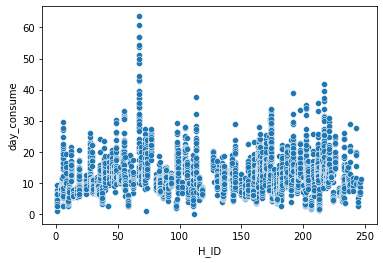

In [34]:
import seaborn as sns

sns.scatterplot(x = 'H_ID', y = 'day_consume', data = df_total_summer)

### 요금제 계산
https://cyber.kepco.co.kr/ckepco/front/jsp/CY/E/E/CYEEHP00101.jsp

In [35]:
# 하계계절
summer_low = pd.DataFrame({'season': 'summer',
                           'type': 'Low', # 주택용전력(저압)
                        'range':[0, 301, 451,1001],
                        'base' : [910, 28178.3, 61313.3, 212893.3],
                        'price':[88.3, 182.9, 275.6,704.5]})
summer_high = pd.DataFrame({'season': 'summer',
                            'type': 'High', # 주택용전력(저압)
                    'range':[0, 301, 451,1001],
                    'base' : [730, 23323.3, 49468.3, 165298.3],
                    'price':[73.3, 142.3, 210.6, 569.6]})
# 기타계절
other_low = pd.DataFrame({'season': 'other',
                          'type': 'Low', # 주택용전력(저압)
                    'range':[0, 201, 401,1001],
                    'base' : [910, 19348.3, 61628.3, 226988.3],
                    'price':[88.3, 182.9, 275.6, 704.5]})
other_high = pd.DataFrame({'season': 'other',
                           'type': 'High', # 주택용전력(저압)
                    'range':[0, 201, 401,1001],
                    'base' : [730, 15993.3, 49253.3, 175613.3],
                    'price':[73.3, 142.3, 210.6,569.6]})

standard_rate_dict= {('summer', 'low'): summer_low, ('other', 'low'):other_low  , ('summer', 'high') :summer_high , ('other', 'high'):other_high}

In [36]:
path = '../'
tou_rate = pd.read_csv(path+'TOU_rate.csv')

In [116]:
power_rate_tou_dict = dict()
def power_rate_time(month, time):
    key_string = f'{month}_{time}'
    
    result = power_rate_tou_dict.get(key_string, 0)
    if not result:
        power_rate_tou_dict[key_string] = tou_rate.loc[(tou_rate['KEY'] == key_string)]["일반형요금"].tolist()[0]
    return result

def tou_cost_month(h_id, month):
    tou_cost = 0
    month_data = df_total_consume.loc[(df_power.H_ID == h_id) & (df_power.month == month), :]
    for idx, day_data in month_data.iterrows():
        costs_by_time = [day_data.iloc[-24 + time] * power_rate_time(day_data['month'], time) for time in range(24)]
        # print(costs_by_time)
        tou_cost += sum(costs_by_time)
    return tou_cost

### 데이터 탐색

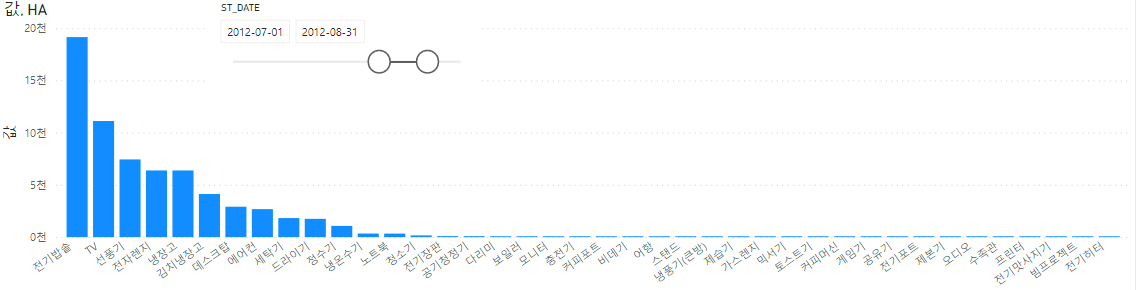

아파트 -> 총사용량으로 계산 테이블 -> 단계 레벨 보기 -> 기본요금 찾기 -> 기본요금 + 요금

In [117]:
def search_month_consume(H_id, month, df_input):
    return df_input.loc[(df_input.H_ID == H_id)&(df_input['month'] == month),'day_consume'].sum()

In [118]:
# 월별 총 사용량
def search_month_consume(H_id, month):
    return df_total_consume.loc[(df_total_consume.H_ID == H_id)&(df_total_consume['month'] == month),'day_consume'].sum()
# 기존 요금제 계산하기
# H_id의 기본 정보 찾기
def search_month_type(H_id, month):
    # 주거 정보 찾기
    if len(df_total_consume[(df_total_consume.H_ID == H_id)&(df_total_consume['APT_TF'] == '아파트')]) >0 :
        type = 'high'
    else : type = 'low'

    # 월별 계절 계산
    if month in [7,8] :
        season = 'summer'
    else : season = 'other'
    return (season,type)

def standard_cost_month(h_id, month):
    key = search_month_type(h_id, month)
    rate_table = standard_rate_dict[key]
    consumtion = search_month_consume(h_id, month)
    
    if consumtion < rate_table.iloc[1,2] : # 1구간
        rate = rate_table.iloc[0,3] + (rate_table.iloc[0,4]*consumtion)
    elif (consumtion < rate_table.iloc[2,2]) : # 2구간
        rate = rate_table.iloc[1,3] + (rate_table.iloc[1,4]*(consumtion-rate_table.iloc[1,2]+1))
    elif (consumtion < rate_table.iloc[3,2]):
        rate = rate_table.iloc[2,3] + (rate_table.iloc[2,4]*(consumtion-rate_table.iloc[2,2]+1))
    else :
        rate = rate_table.iloc[3,3] + (rate_table.iloc[3,4]*(consumtion-rate_table.iloc[3,2]+1))
    return rate

In [119]:
season['summer']

[6, 7, 8]

In [120]:
# %load df_calculate.py

df_monthly_cost = df_total_consume[['H_ID', 'month']].drop_duplicates()

# 요금 계산해서 flg
#standard
df_monthly_cost['standard'] = 0
for idx, id in df_monthly_cost.iterrows():
    id['standard'] = standard_cost_month(id['H_ID'], id['month'])

df_monthly_cost['tou'] = 0
for idx, id in df_monthly_cost.iterrows():
    id['tou'] = tou_cost_month(id['H_ID'], id['month'])
    
df_monthly_cost['desc_cost'] = 0
for idx, id in df_monthly_cost.iterrows():
    id['desc_cost'] = id['tou'] - id['standard']


In [138]:
df_monthly_cost[df_monthly_cost['desc_cost']  > 30000
                ]

,H_ID,month,standard,tou,desc_cost
15675,198,3,95770,53058,-42712
29093,174,4,101450,54203,-47247
30969,187,4,91358,51176,-40182
45908,174,5,97896,52978,-44918
69455,77,9,134948,66591,-68357
76542,174,9,95581,51989,-43592
143030,67,8,219024,167542,-51482


In [123]:
df_monthly_cost.to_csv('../csv_files/monthly_cost.csv', encoding='euc-kr')

In [131]:
df_monthly_cost[df_monthly_cost['desc_cost'] < -40000]

,H_ID,month,standard,tou,desc_cost
15675,198,3,95770,53058,-42712
29093,174,4,101450,54203,-47247
30969,187,4,91358,51176,-40182
45908,174,5,97896,52978,-44918
69455,77,9,134948,66591,-68357
76542,174,9,95581,51989,-43592
143030,67,8,219024,167542,-51482


In [93]:
grp_summer = df_total_summer.groupby(['H_ID', 'month']).mean()
grp_summer.insert(1,'standard', 0)
grp_summer.insert(1,'tou', 0)
grp_summer.insert(1,'desc_cost', 0)
grp_summer

day_consume  desc_cost  tou  standard        day   weekday  \
H_ID month                                                               
1    7         3.550190          0    0         0  20.095238  2.761905   
     8         4.701828          0    0         0  16.310345  2.827586   
4    6         8.060375          0    0         0  16.375000  2.750000   
     7         8.374034          0    0         0  17.000000  2.931034   
     8         8.107333          0    0         0  16.366667  2.900000   
...                 ...        ...  ...       ...        ...       ...   
243  8        16.563750          0    0         0  27.500000  3.125000   
244  8         3.888000          0    0         0  27.000000  4.666667   
245  8         8.096750          0    0         0  29.500000  2.500000   
246  8         8.553200          0    0         0  29.000000  2.000000   
247  8        11.324000          0    0         0  31.000000  4.000000   

                  H0        H1        H2        H3  ...       H14       H15  \
H_ID month                                          ...                       
1    7      0.225762  0.150667  0.148667  0.132524  ...  0.115190  0.112143   
     8      0.496690  0.237483  0.185069  0.180034  ...  0.131897  0.128931   
4    6      0.230750  0.211375  0.214250  0.207000  ...  0.370625  0.338625   
     7      0.251379  0.219931  0.219241  0.225862  ...  0.374345  0.345552   
     8      0.276533  0.230800  0.225800  0.224633  ...  0.359700  0.339000   
...              ...       ...       ...       ...  ...       ...       ...   
243  8      0.330375  0.371125  0.348500  0.374000  ...  1.042250  1.102875   
244  8      0.123667  0.091333  0.105333  0.128000  ...  0.119000  0.308333   
245  8      0.281250  0.263250  0.271250  0.269000  ...  0.507750  0.363500   
246  8      0.305000  0.308000  0.315000  0.291400  ...  0.496000  0.439200   
247  8      0.373000  0.388000  0.349000  0.296000  ...  0.619000  0.656000   

                 H16       H17       H18       H19       H20       H21  \
H_ID month                                                               
1    7      0.112238  0.120000  0.124476  0.145476  0.185667  0.222095   
     8      0.140724  0.155828  0.149759  0.212069  0.252241  0.277034   
4    6      0.332125  0.344375  0.386375  0.472125  0.555875  0.479250   
     7      0.372621  0.362000  0.365172  0.457414  0.493759  0.525897   
     8      0.338700  0.344900  0.356300  0.465233  0.501767  0.522533   
...              ...       ...       ...       ...       ...       ...   
243  8      1.079250  1.032000  1.031500  0.978125  0.597000  0.554875   
244  8      0.163000  0.162333  0.150667  0.173000  0.285000  0.377333   
245  8      0.409500  0.432750  0.476000  0.391250  0.288250  0.301500   
246  8      0.512800  0.479400  0.512400  0.363400  0.260000  0.319600   
247  8      0.654000  0.376000  0.646000  0.651000  0.632000  0.662000   

                 H22       H23  
H_ID month                      
1    7      0.275048  0.334381  
     8      0.301448  0.406759  
4    6      0.517000  0.354625  
     7      0.521552  0.452931  
     8      0.493000  0.408333  
...              ...       ...  
243  8      0.354125  0.356625  
244  8      0.261667  0.136000  
245  8      0.259500  0.274250  
246  8      0.283000  0.300600  
247  8      0.627000  0.706000  

[327 rows x 30 columns]

In [94]:
for idx, data in grp_summer.iterrows():
    hid, month = idx
    month_row = df_monthly_cost[(df_monthly_cost['H_ID'] == hid) & (df_monthly_cost['month'] == month)]
    tou, standard, desc_cost = month_row['tou'].tolist()[0], month_row['standard'].tolist()[0], month_row['desc_cost'].tolist()[0]
    grp_summer.loc[idx, 'tou'] = tou
    grp_summer.loc[idx, 'standard'] = standard
    grp_summer.loc[idx, 'desc_cost'] = desc_cost

In [95]:
grp_summer.drop(['standard', 'tou', 'day', 'weekday'], axis = 1, inplace = True)

In [96]:
def scaling_row(df_input):
    print(len(df_input))
    for row in range(len(df_input)):
        for col in range(2, 26):
        # 시간대별 전력 scaling
            
            df_input.iloc[row,col] /= df_input.iloc[row,0]
    return df_input

In [97]:
grp_scaled =  scaling_row(grp_summer)

327


In [102]:
grp_scaled.loc[:,'day_consume'] = grp_scaled.loc[:,'day_consume'].apply(lambda x: (x - grp_scaled.loc[:,'day_consume'].mean()) / grp_scaled.loc[:,'day_consume'].std())
grp_scaled.loc[:,'desc_cost'] = grp_scaled.loc[:,'desc_cost'].apply(lambda x: (x - grp_scaled.loc[:,'desc_cost'].mean()) / grp_scaled.loc[:,'desc_cost'].std())

In [103]:
grp_scaled

day_consume  desc_cost        H0        H1        H2        H3  \
H_ID month                                                                   
1    7        -1.734404  -0.832633  0.063591  0.042439  0.041876  0.037329   
     8        -1.473571  -0.210028  0.105638  0.050509  0.039361  0.038290   
4    6        -0.712898  -0.825191  0.028628  0.026224  0.026581  0.025681   
     7        -0.641858   0.609304  0.030019  0.026263  0.026181  0.026972   
     8        -0.702263   0.592608  0.034109  0.028468  0.027851  0.027707   
...                 ...        ...       ...       ...       ...       ...   
243  8         1.213020  -0.745658  0.019946  0.022406  0.021040  0.022579   
244  8        -1.657894  -1.399325  0.031807  0.023491  0.027092  0.032922   
245  8        -0.704660  -1.329694  0.034736  0.032513  0.033501  0.033223   
246  8        -0.601279  -1.295267  0.035659  0.036010  0.036828  0.034069   
247  8         0.026276  -0.779762  0.032939  0.034264  0.030819  0.026139   

                  H4        H5        H6        H7  ...       H14       H15  \
H_ID month                                          ...                       
1    7      0.033439  0.033251  0.035451  0.032379  ...  0.032446  0.031588   
     8      0.030377  0.032702  0.029314  0.031037  ...  0.028052  0.027421   
4    6      0.024968  0.026658  0.026317  0.031559  ...  0.045981  0.042011   
     7      0.024279  0.026173  0.030748  0.039935  ...  0.044703  0.041265   
     8      0.026828  0.027818  0.027971  0.035618  ...  0.044367  0.041814   
...              ...       ...       ...       ...  ...       ...       ...   
243  8      0.021915  0.025447  0.023810  0.019342  ...  0.062924  0.066584   
244  8      0.037380  0.031464  0.034465  0.030350  ...  0.030607  0.079304   
245  8      0.033933  0.032359  0.036342  0.030907  ...  0.062710  0.044895   
246  8      0.036478  0.030772  0.029626  0.030983  ...  0.057990  0.051349   
247  8      0.024461  0.019516  0.023931  0.046097  ...  0.054663  0.057930   

                 H16       H17       H18       H19       H20       H21  \
H_ID month                                                               
1    7      0.031615  0.033801  0.035062  0.040977  0.052298  0.062559   
     8      0.029930  0.033142  0.031851  0.045104  0.053648  0.058921   
4    6      0.041205  0.042724  0.047935  0.058574  0.068964  0.059458   
     7      0.044497  0.043229  0.043608  0.054623  0.058963  0.062801   
     8      0.041777  0.042542  0.043948  0.057384  0.061890  0.064452   
...              ...       ...       ...       ...       ...       ...   
243  8      0.065157  0.062305  0.062275  0.059052  0.036043  0.033499   
244  8      0.041924  0.041752  0.038752  0.044496  0.073302  0.097051   
245  8      0.050576  0.053447  0.058789  0.048322  0.035601  0.037237   
246  8      0.059954  0.056049  0.059907  0.042487  0.030398  0.037366   
247  8      0.057753  0.033204  0.057047  0.057489  0.055811  0.058460   

                 H22       H23  
H_ID month                      
1    7      0.077474  0.094187  
     8      0.064113  0.086511  
4    6      0.064141  0.043996  
     7      0.062282  0.054088  
     8      0.060809  0.050366  
...              ...       ...  
243  8      0.021380  0.021530  
244  8      0.067301  0.034979  
245  8      0.032050  0.033872  
246  8      0.033087  0.035145  
247  8      0.055369  0.062345  

[327 rows x 26 columns]

In [107]:
scaled_df = grp_scaled

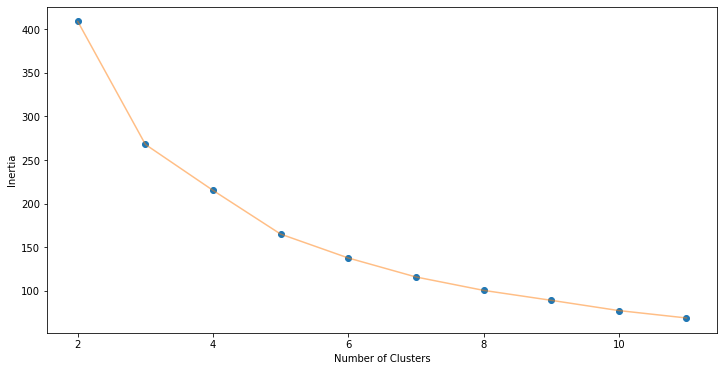

In [108]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold

# elbow method를 통해 군집의 개수 결정
def change_n_clusters(n_clusters, data):
    sum_of_squared_distance = []
    for n_cluster in n_clusters:
        kmeans = KMeans(n_clusters=n_cluster)
        kmeans.fit(data)
        sum_of_squared_distance.append(kmeans.inertia_)
        
    plt.figure(1 , figsize = (12, 6))
    plt.plot(n_clusters , sum_of_squared_distance , 'o')
    plt.plot(n_clusters , sum_of_squared_distance , '-' , alpha = 0.5)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')

change_n_clusters([2,3,4,5,6,7,8,9,10,11], scaled_df)

In [109]:
kmeans = KMeans(n_clusters=4, random_state = 2)
km_cluster = kmeans.fit_predict(scaled_df)

In [111]:
df_clust = grp_summer.copy()
df_clust['km_cluster'] = km_cluster
df_clust.head()

day_consume  desc_cost        H0        H1        H2        H3  \
H_ID month                                                                   
1    7        -1.734404  -0.832633  0.063591  0.042439  0.041876  0.037329   
     8        -1.473571  -0.210028  0.105638  0.050509  0.039361  0.038290   
4    6        -0.712898  -0.825191  0.028628  0.026224  0.026581  0.025681   
     7        -0.641858   0.609304  0.030019  0.026263  0.026181  0.026972   
     8        -0.702263   0.592608  0.034109  0.028468  0.027851  0.027707   

                  H4        H5        H6        H7  ...       H15       H16  \
H_ID month                                          ...                       
1    7      0.033439  0.033251  0.035451  0.032379  ...  0.031588  0.031615   
     8      0.030377  0.032702  0.029314  0.031037  ...  0.027421  0.029930   
4    6      0.024968  0.026658  0.026317  0.031559  ...  0.042011  0.041205   
     7      0.024279  0.026173  0.030748  0.039935  ...  0.041265  0.044497   
     8      0.026828  0.027818  0.027971  0.035618  ...  0.041814  0.041777   

                 H17       H18       H19       H20       H21       H22  \
H_ID month                                                               
1    7      0.033801  0.035062  0.040977  0.052298  0.062559  0.077474   
     8      0.033142  0.031851  0.045104  0.053648  0.058921  0.064113   
4    6      0.042724  0.047935  0.058574  0.068964  0.059458  0.064141   
     7      0.043229  0.043608  0.054623  0.058963  0.062801  0.062282   
     8      0.042542  0.043948  0.057384  0.061890  0.064452  0.060809   

                 H23  km_cluster  
H_ID month                        
1    7      0.094187           3  
     8      0.086511           3  
4    6      0.043996           3  
     7      0.054088           2  
     8      0.050366           2  

[5 rows x 27 columns]

<AxesSubplot:xlabel='day_consume', ylabel='desc_cost'>

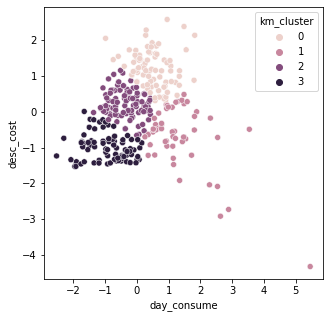

In [112]:
plt.figure(figsize = (5,5)) # 가로 10. 세로 5

import seaborn as sns
sns.scatterplot(x='day_consume', y = 'desc_cost', data = df_clust, hue = 'km_cluster')

In [113]:
df_clust.to_csv('../csv_files/cluster.csv')

In [115]:
df_except_total_spring

,H_ID,HA,ST_DATE,APT_TF,M2,PersonCount,day_consume,month,day,weekday,...,H14,H15,H16,H17,H18,H19,H20,H21,H22,H23
18,1,냉장고,2012-03-19,아파트,20평~29평,2인이하,1.518,3,19,0,...,0.054,0.054,0.056,0.056,0.057,0.052,0.159,0.148,0.061,0.040
19,1,노트북,2012-03-19,아파트,20평~29평,2인이하,0.141,3,19,0,...,0.006,0.006,0.006,0.007,0.006,0.005,0.000,0.001,0.023,0.030
20,1,세탁기,2012-03-19,아파트,20평~29평,2인이하,0.025,3,19,0,...,0.001,0.004,0.002,0.002,0.004,0.003,0.001,0.001,0.000,0.001
22,1,전자렌지,2012-03-19,아파트,20평~29평,2인이하,0.069,3,19,0,...,0.003,0.001,0.003,0.001,0.001,0.002,0.027,0.001,0.001,0.002
23,1,냉장고,2012-03-20,아파트,20평~29평,2인이하,0.950,3,20,1,...,0.040,0.040,0.039,0.040,0.039,0.039,0.039,0.039,0.044,0.039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49664,303,전기밥솥,2012-05-30,아파트,1평~19평,3인,0.527,5,30,2,...,0.035,0.035,0.036,0.035,0.031,0.002,0.000,0.001,0.000,0.002
49666,303,TV,2012-05-31,아파트,1평~19평,3인,0.990,5,31,3,...,0.001,0.000,0.001,0.000,0.055,0.136,0.135,0.131,0.050,0.135
49667,303,김치냉장고,2012-05-31,아파트,1평~19평,3인,4.584,5,31,3,...,0.191,0.194,0.195,0.197,0.197,0.195,0.194,0.192,0.190,0.188
49668,303,데스크탑,2012-05-31,아파트,1평~19평,3인,1.456,5,31,3,...,0.061,0.055,0.060,0.052,0.036,0.041,0.063,0.065,0.074,0.077
